# Dimensionality reduction tutorial

This is a high-level intro to dimensionality reduction as a tool to visualize data and aid in prediction.

It uses principal components analysis, t-SNE, and k-nearest neighbors classifiers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import scipy.stats
from scipy.ndimage.filters import gaussian_filter1d,gaussian_filter
from six.moves import urllib
import os
import sklearn.decomposition

def smooth_bin(data, N=20):
    ''' smooth data using cumsum over axis=0 with window N'''
    pad = np.zeros((int(N/2), data.shape[1]))
    dsmooth = np.concatenate((pad, data, pad), axis=0)
    # in X
    cumsum = np.cumsum(dsmooth, axis=0).astype(np.float32)
    dsmooth = (cumsum[N:] - cumsum[:-N]) / float(N)
    return dsmooth

# download 2-photon data
if not os.path.isfile('data/stimspont.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    with urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/stimspont.npy') as response:
        with open('data/stimspont.npy','wb') as f:
            f.write(response.read())

Install umap if you want to play with it

In [11]:
# before we start install UMAP if you are interested
# (see documentation here https://github.com/lmcinnes/umap)
!pip install umap-learn

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Load in neural data and take only a third of neurons (to speed up processing).

Also we z-score neural data by spontaneous activity mean and variance. This is a data "cleaning" step that helps to control for variations in inferred firing rates in data.

In [91]:
# now let's decompose the neural responses!

# load downloaded data
dat = np.load('data/stimspont.npy', allow_pickle=True)
dat = dat.item()
resp  = dat['resp'] # stimulus responses x neurons
istim  = dat['istim'] # identity of stimulus (0-31)
spont = dat['spont'].T #  timepoints x neurons

# only use a third of neurons to speed up analysis
resp = resp[:,::3]
spont = spont[:,::3]

# zscore data by spont activity
resp = (resp - spont.mean(axis=0)) / spont.std(axis=0)
spont = (spont - spont.mean(axis=0)) / spont.std(axis=0)

del dat

## Spontaneous neural activity rasters

This is neural activity recorded in visual cortex when the mouse is not viewing any images, but the mouse is free to run around on the ball.

Plot the neural activity as a matrix of neurons by timepoints.

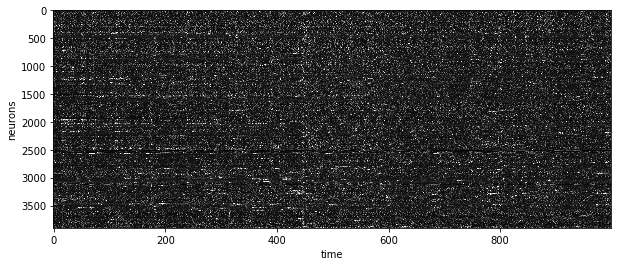

In [92]:
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.imshow(spont.T[:,:1000], cmap='gray', vmin=-1, vmax=5, aspect='auto')
ax.set_ylabel('neurons')
ax.set_xlabel('time')
plt.show()

### principal components analysis

Compute the principal components of the neural data and sort the neurons by their 1st PC weights. After sorting we smooth across neurons to help to visualize the patterns of activity.

Plot the activity raster and on top plot the 1st PC in time.

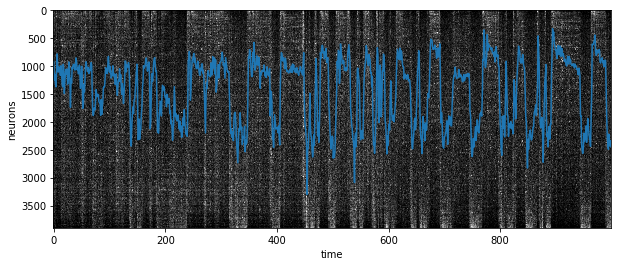

In [93]:
# Compute principal components

from sklearn.decomposition import PCA

v = PCA(n_components=200).fit_transform(spont)
u = spont.T @ v
vp = (v - v.min()) / (v.max()-v.min()) # squish to 0-1 for plotting

isort = np.argsort(u[:,0])
# smooth across sorted neurons
smoothed_sp = smooth_bin(spont[:,isort].T.copy(), 20)

# make plot
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
# plot spike raster
ax.imshow(smoothed_sp[:,:1000], cmap='gray', vmin=-0.5, vmax=2, aspect='auto')
ax.set_ylabel('neurons')
ax.set_xlabel('time')
# plot 1st PC time series
ax.plot(vp[:1000,0]*spont.shape[1])
plt.show()


### t-SNE analysis

Compute a 1D embedding of the neurons using the top PCs of neural data (the PCs are used to speed up processing). 

The neurons are then sorted by their embedding position and the activity smoothed across neurons.

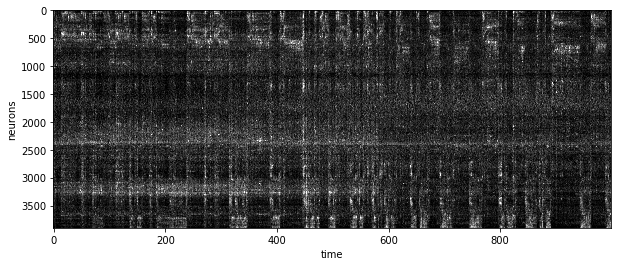

In [101]:
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding

# run some TSNE here!!
# and/or other dimensionality reductions above
# (I am running t-SNE on the PCA output)
embedding = TSNE(n_components=1).fit_transform(u)

isort = np.argsort(embedding[:,0])
# smooth across sorted neurons
smoothed_sp = smooth_bin(spont[:,isort].T.copy(), 20)

# make plot
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
# plot spike raster
ax.imshow(smoothed_sp[:,:1000], cmap='gray', vmin=-0.5, vmax=2, aspect='auto')
ax.set_ylabel('neurons')
ax.set_xlabel('time')
plt.show()

## Neural responses to stimuli

In this recording, 32 different natural images were shown to mice approximately 90 times each in a random order. resp is stimulus presentations by neurons.

First, let's visualize the average response of each neuron to each stimulus, we will flip the axes and now put neurons on the x-axis.

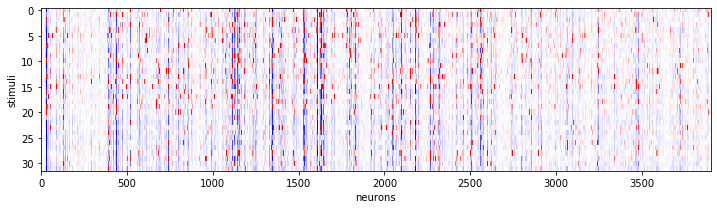

In [160]:
### STIMULUS RESPONSES
# show average responses of neurons to the 32 stimuli

nstim = 32
avresp = np.zeros((nstim, resp.shape[1]))
for i in range(nstim):
    avresp[i] = resp[istim==i].mean(axis=0)
    
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax.imshow(avresp, cmap='bwr', aspect='auto', vmin=-1, vmax=1)
ax.set_ylabel('stimuli')
ax.set_xlabel('neurons')
plt.show()

### t-SNE of average stimulus responses

Compute a 1D embedding of the neurons' average responses to the 32 stimuli. 

The neurons are then sorted by their embedding position and the activity smoothed across neurons.

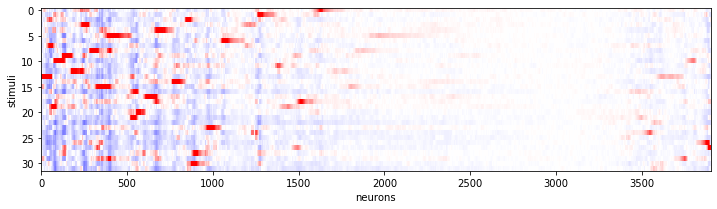

In [121]:
# sort across neurons and view average responses

embedding = TSNE(n_components=1).fit_transform(avresp.T)
isort = np.argsort(embedding[:,0])

smoothed_av = smooth_bin(avresp[:,isort].T.copy(), 20).T

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax.imshow(smoothed_av, cmap='bwr', aspect='auto', vmin=-1, vmax=1)
ax.set_ylabel('stimuli')
ax.set_xlabel('neurons')
plt.show()


## Decoding stimulus identity from neural responses

We can see that there is selectivity in neural responses. Can we decode from neural activity on a single-trial level?

We have 2832 stimulus presentations. We will first embed these stimulus presentations in a 2D t-SNE to visualize them.

In [123]:
### DECODE SINGLE-TRIAL RESPONSES

# let's embed ALL stimuli now
embedding = TSNE(n_components=2,perplexity=30).fit_transform(resp)

# can also try umap if pip installed
#import umap
#model = umap.UMAP(n_neighbors=15, min_dist=0.01,n_components=8) # can use many components!
#embedding = model.fit_transform(resp)

### t-SNE of single-trial responses

We next scatter plot each stimulus presentation in this new coordinate system. We will color each point based on the stimulus identity using the 'c' function in plt.scatter.

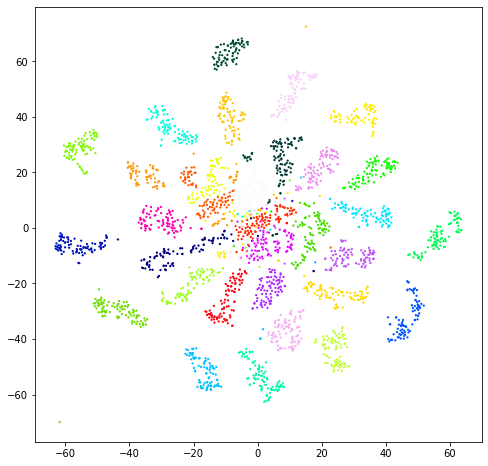

In [152]:
# plot results here
plt.figure(figsize=(8,8))
# each point is colored based on stimulus identity
plt.scatter(embedding[:,0], embedding[:,1], c=istim, cmap='gist_ncar',marker='.', s=6)
plt.show()

### classification of stimulus responses

Try to predict the identity of a stimulus given the neural activity. We will use a k-nearest neighbor classifier. 

In [145]:
# classify results
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# classifier
n_neighbors = 5
clf = KNeighborsClassifier(n_neighbors, weights='distance')

# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(resp, istim, test_size=0.25, random_state=42)

# fit classifier using half of the data
svc = clf.fit(X_train, y_train)
# predict stimuli from other half
istim_pred = clf.predict(X_test)
accuracy   = (istim_pred==y_test).mean()
print('using full data coordinates, accuracy = %0.3f'%accuracy)


using full data coordinates, accuracy = 0.927


Try to predict the identity of a stimulus given the embedding position in the **t-SNE**. We will use a k-nearest neighbor classifier. 

In [148]:
# use low-dimensional data to classify now

n_neighbors = 5
clf = KNeighborsClassifier(n_neighbors, weights='distance')

X_train, X_test, y_train, y_test = train_test_split(embedding, istim, test_size=0.25, random_state=42)
svc = clf.fit(X_train, y_train)
# predict stimuli from other half
istim_pred = clf.predict(X_test)
accuracy   = (istim_pred==y_test).mean()
print('using t-SNE coordinates, accuracy = %0.3f'%accuracy)


using t-SNE coordinates, accuracy = 0.976


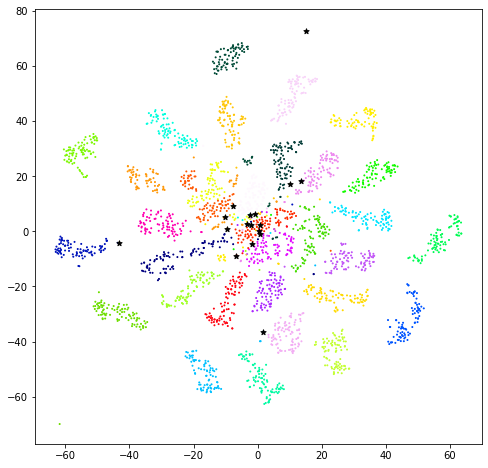

In [151]:
# visualize errors (easy in t-SNE)

icorrect   = istim_pred==y_test

plt.figure(figsize=(8,8))
# each point is colored based on stimulus identity
plt.scatter(embedding[:,0], embedding[:,1], c=istim, cmap='gist_ncar',marker='.', s=4)
# new markers for incorrect points
plt.scatter(X_test[~icorrect,0], X_test[~icorrect,1], color='k', cmap='gist_ncar', marker='*', s=30)
plt.show()

In [ ]:
### SEE IF YOU CAN BEAT t-SNE

# multi-class SVM
from sklearn.SVM import SVC

# can try linear regression, but will need to round outputs
from sklearn.linear_model import Ridge

